In [219]:
import cv2
import h5py
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.manifold import TSNE
from PIL import Image
from scipy.ndimage import binary_fill_holes
from scipy.special import ellipe

## Example Run Multicore TSNE on the MNIST Dataset

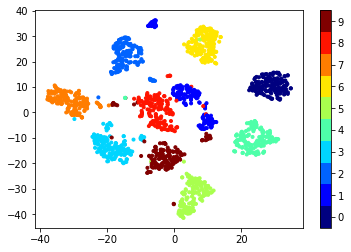

In [13]:
from sklearn.datasets import load_digits
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt

digits = load_digits()
embeddings = TSNE(n_jobs=4).fit_transform(digits.data)
vis_x = embeddings[:, 0]
vis_y = embeddings[:, 1]
plt.scatter(vis_x, vis_y, c=digits.target, cmap=plt.cm.get_cmap("jet", 10), marker='.')
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

## Run t-SNE on the full cell features dataset.

In [14]:
PATH_TO_ALL_CELL_FEATURES = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/cell_features_all.csv"

In [ ]:
cell_shapes_all_features_df = pd.read_csv(PATH_TO_ALL_CELL_FEATURES)
print(len(cell_shapes_all_features_df))

In [21]:
# Optional: restrict the dataset to only the neoplastic cells.
cell_shapes_all_features_df = cell_shapes_all_features_df[cell_shapes_all_features_df["cell_type"] == 1]
# Remove all rows with label == -1 (Excluded).
cell_shapes_all_features_df = cell_shapes_all_features_df[cell_shapes_all_features_df[LABEL] != -1]
print(len(cell_shapes_all_features_df))

4376876


In [25]:
# Sample 50000 rows from the dataframe (since tSNE is very slow on the full dataset with 7997643 rows).
num_rows = 10000
cell_shapes_sample_df = cell_shapes_all_features_df.sample(n=num_rows,replace=False)

In [26]:
features = ["hull_area", "hull_perimeter", "min_diameter", "max_diameter",
            "min_angle", "max_angle", "esf", "csf", "sf1", "sf2", "elongation",
            "convexity", "compactness"]

x = cell_shapes_sample_df[features].to_numpy()
y = cell_shapes_sample_df[["label"]].to_numpy()

In [28]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x) 

Performing t-SNE using 1 cores.
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 1000 of 10000
 - point 2000 of 10000
 - point 3000 of 10000
 - point 4000 of 10000
 - point 5000 of 10000
 - point 6000 of 10000
 - point 7000 of 10000
 - point 8000 of 10000
 - point 9000 of 10000
 - point 10000 of 10000
Done in 1.00 seconds (sparsity = 0.011564)!
Learning embedding...
Iteration 51: error is 88.212129 (50 iterations in 5.00 seconds)
Iteration 101: error is 75.768305 (50 iterations in 4.00 seconds)
Iteration 151: error is 72.133444 (50 iterations in 5.00 seconds)
Iteration 201: error is 70.383835 (50 iterations in 6.00 seconds)
Iteration 251: error is 69.355064 (50 iterations in 5.00 seconds)
Iteration 301: error is 2.487895 (50 iterations in 4.00 seconds)
Iteration 351: error is 2.090818 (50 iterations in 5.00 seconds)
Iteration 401: error is 1.834985 (50 iterations in 5.00 seconds)
Iteration 451: error is 1.658928 (

[Text(0.5, 1.0, 'HoverNet Features T-SNE projection')]

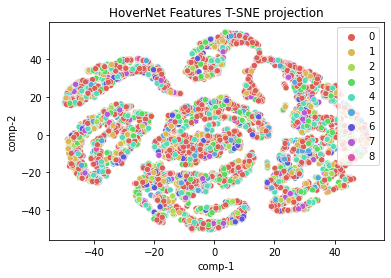

In [30]:
df = pd.DataFrame()
# DLBCL vs non-DLBCL
# y_subset[y_subset > 0] = 1
# num_colors = 2
df["y"] = y.squeeze()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
num_colors = 9

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", num_colors),
                data=df).set(title="HoverNet Features T-SNE projection") 

## Run t-SNE on the Aggregated Cell Features (after computing mean across all patches/cells for a given patient)

In [264]:
PATH_TO_OUTPUT_CELLS = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells"
PATH_TO_OUTPUT_CELL_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "cell_shapes_features_v1")
PATH_TO_CELLS_HDF5 = os.path.join(PATH_TO_OUTPUT_CELLS, "cells.hdf5")
PATH_TO_AGG_GEO_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "geometric_features")

PATH_TO_RAW_DATA = "/deep/group/aihc-bootcamp-fall2021/lymphoma/raw"
PATH_TO_DIAGNOSES = os.path.join(PATH_TO_RAW_DATA, "core_labels.csv")
TMA_ID = "TMA ID"
CASE = "CASE"
LABEL = "label"

In [261]:
PATH_TO_OUTPUT_CELLS = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells"
PATH_TO_AGG_GEO_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "geometric_features")

geo_features_files = glob.glob(os.path.join(PATH_TO_AGG_GEO_FEATURES, "*_geo_features.csv"))
geo_features_files

['/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma1_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma2_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma3_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma5_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma4_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma6b_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma8_geo_features.csv',
 '/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/geometric_features/tma6a_geo_features.csv']

In [262]:
geo_features_df = pd.concat([pd.read_csv(filename) for filename in geo_features_files])

In [265]:
tma_case_to_diagnosis = pd.read_csv(PATH_TO_DIAGNOSES, delimiter=',')
tma_case_to_diagnosis[CASE] = tma_case_to_diagnosis[CASE].apply(lambda patient_id : patient_id.replace(" ", ""))
tma_case_to_diagnosis.head()

,Unnamed: 0,TMA ID,CASE,2017 WHO DIAGNOSIS,CLPA Diagnostic Bin,label
0,0,1,E0001B,NOT ON TMA,Excluded,-1
1,1,1,E0002B,NON-DIAGNOSTIC,Excluded,-1
2,2,1,E0003B,Classic Hodgkin Lymphoma,HL,1
3,3,1,E0004B,"Follicular lymphoma, grade 1-2",FL,3
4,4,1,E0005B,"Diffuse large B cell lymphoma, NOS",DLBCL,0


In [266]:
labels = []
for i, (tma_id, patient_id) in enumerate(zip(geo_features_df["tma_id"], geo_features_df["patient_id"])):
    if i % 10000 == 0:
        print(i)
    tma_id_key = int(tma_id[3]) # tma1 -> 1, tma6a -> 6, tma6b -> 6
    patient_id_key = patient_id.split("_")[0]
    condition = (tma_case_to_diagnosis[CASE] == patient_id_key) & (tma_case_to_diagnosis[TMA_ID] == tma_id_key)
    tma_case_to_diagnosis_row = tma_case_to_diagnosis[condition]
    if len(tma_case_to_diagnosis_row[LABEL].values) == 0:
        print(f"Could not find diagnosis for: {patient_id_key}")
        label = -1
    elif len(tma_case_to_diagnosis_row[LABEL].values) > 1:
        print(f"ERROR: There should only be one entry for a specific TMA ID X patient ID")
        label = -1
    else:
        label = tma_case_to_diagnosis_row[LABEL].values[0]
    labels.append(label)
    i += 1
geo_features_df[LABEL] = labels

0
Could not find diagnosis for: E0147
Could not find diagnosis for: E0147


In [268]:
geo_features_df.to_csv(os.path.join(PATH_TO_AGG_GEO_FEATURES, "geo_features_all.csv"))

In [270]:
geo_features_df.head()
print(len(geo_features_df))

1450


In [272]:
# Remove all rows with label == -1 (Excluded).
geo_features_df = geo_features_df[geo_features_df[LABEL] != -1]
print(len(geo_features_df))

1201


In [273]:
features = ["hull_area_mean", "hull_perimeter_mean", "min_diameter_mean", "max_diameter_mean",
            "min_angle_mean", "max_angle_mean", "esf_mean", "csf_mean", "sf1_mean", "sf2_mean", "elongation_mean",
            "convexity_mean", "compactness_mean"]

x = geo_features_df[features].to_numpy()
y = geo_features_df[["label"]].to_numpy()

In [274]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x) 

/deep/u/vivek96/miniconda3/envs/aihc/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/deep/u/vivek96/miniconda3/envs/aihc/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1201 samples in 0.098s...
[t-SNE] Computed neighbors for 1201 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1201
[t-SNE] Computed conditional probabilities for sample 1201 / 1201
[t-SNE] Mean sigma: 11.200980
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.981899
[t-SNE] KL divergence after 1000 iterations: 0.617500


[Text(0.5, 1.0, 'HoverNet Features T-SNE projection')]

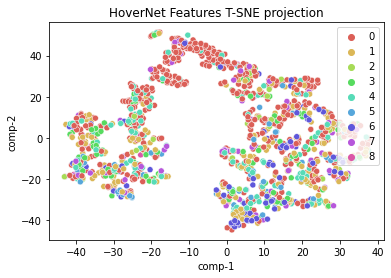

In [275]:
df = pd.DataFrame()
# DLBCL vs non-DLBCL
# y_subset[y_subset > 0] = 1
# num_colors = 2
df["y"] = y.squeeze()
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
num_colors = 9

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", num_colors),
                data=df).set(title="HoverNet Features T-SNE projection") 

## Create box plots for each feature

In [13]:
PATH_TO_OUTPUT_CELLS = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells"
PATH_TO_ALL_CELL_FEATURES = os.path.join(PATH_TO_OUTPUT_CELLS, "cell_features_all.csv")
PATH_TO_OUTPUT_PLOTS = os.path.join(PATH_TO_OUTPUT_CELLS, "boxplots")

In [217]:
cell_shapes_all_features_df = pd.read_csv(PATH_TO_ALL_CELL_FEATURES)
print(f"Num rows in cell features dataset {len(cell_shapes_all_features_df)}")
cell_shapes_all_features_df = cell_shapes_all_features_df[cell_shapes_all_features_df["long_axis"] <= 1000]
print(f"Num rows in cell features dataset {len(cell_shapes_all_features_df)}")

# Optional: restrict the dataset to only the neoplastic cells.
# cell_shapes_all_features_df = cell_shapes_all_features_df[cell_shapes_all_features_df["cell_type"] == 1]
# print(f"Num rows in cell features dataset {len(cell_shapes_all_features_df)} after restricting to neoplastic cells.")

Num rows in cell features dataset 7997643
Num rows in cell features dataset 7997624


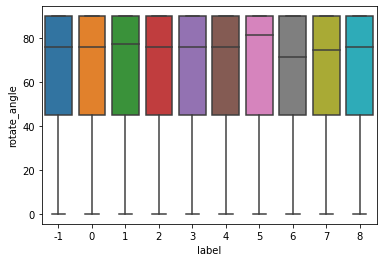

In [220]:
ax = sns.boxplot(x="label", y="rotate_angle", data=cell_shapes_all_features_df)

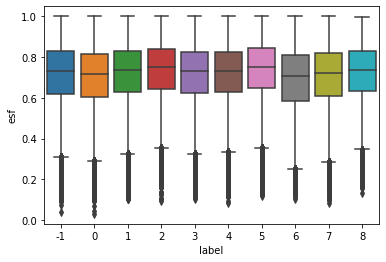

In [221]:
ax = sns.boxplot(x="label", y="esf", data=cell_shapes_all_features_df)

In [222]:
FEATURES = ["rotate_angle", "short_axis", "long_axis", "ellipse_perim", "ellipse_area", "rect_center_x",
            "rect_center_y", "rect_width", "rect_height", "ellipse_centroid_x", "ellipse_centroid_y", "hull_area",
            "hull_perimeter", "min_diameter", "max_diameter", "min_angle", "max_angle", "esf",
            "csf", "sf1", "sf2", "elongation", "convexity", "compactness"]

/tmp/ipykernel_1748285/2160655757.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


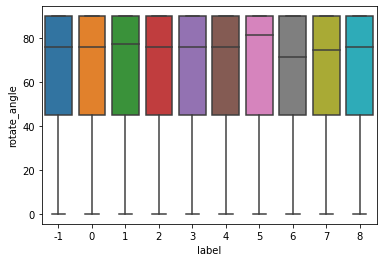

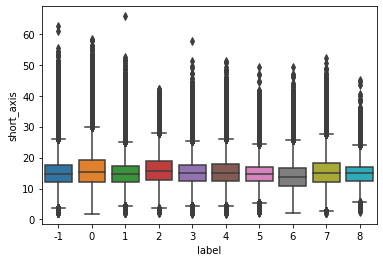

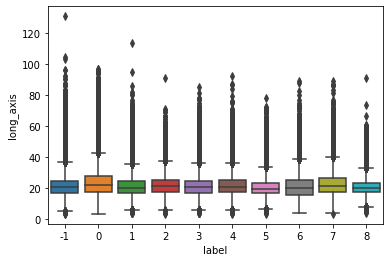

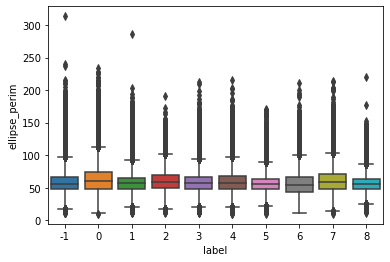

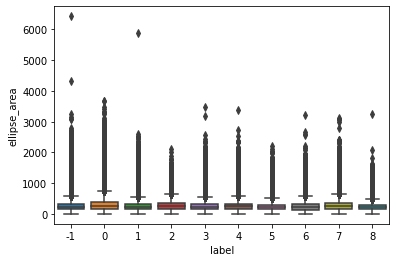

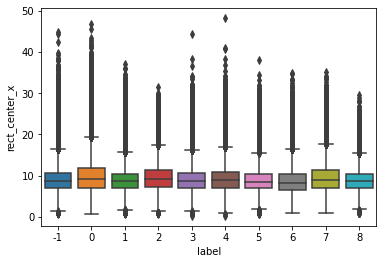

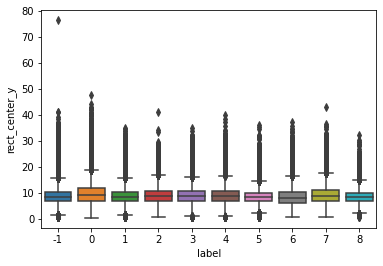

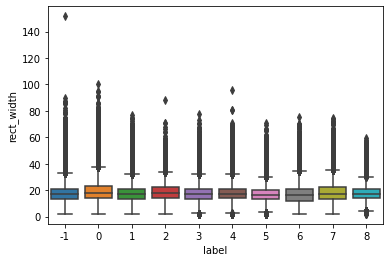

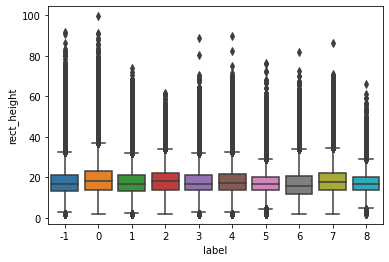

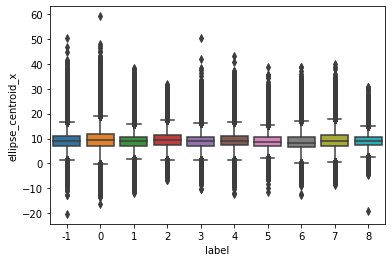

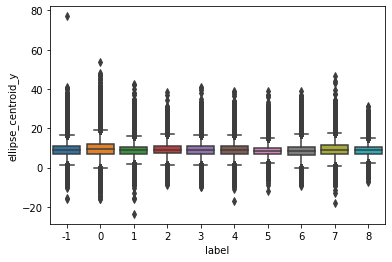

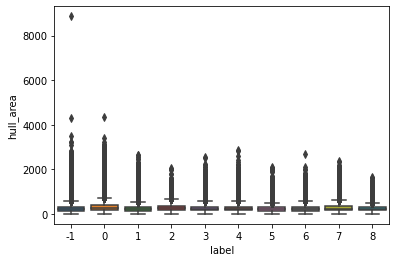

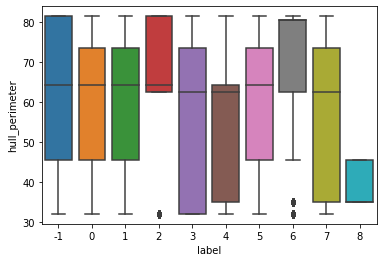

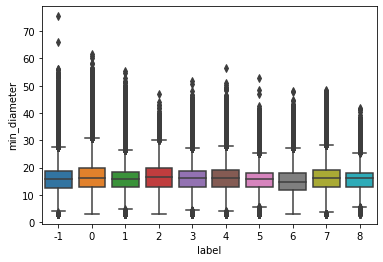

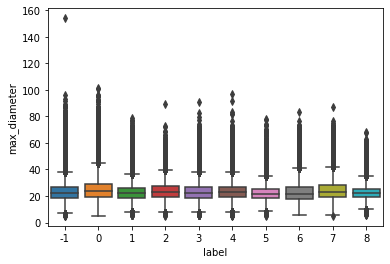

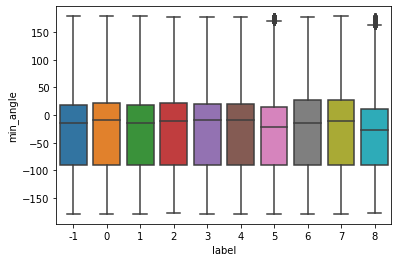

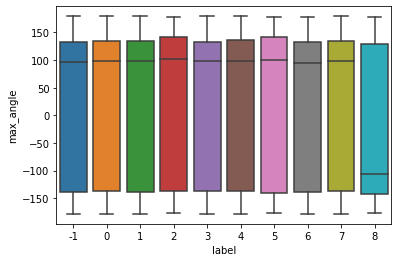

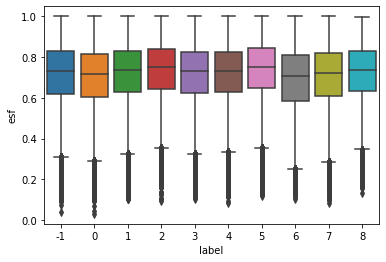

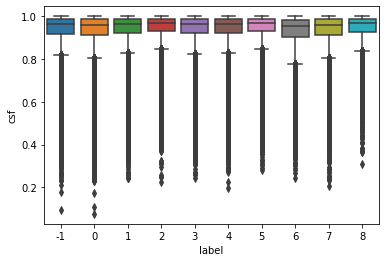

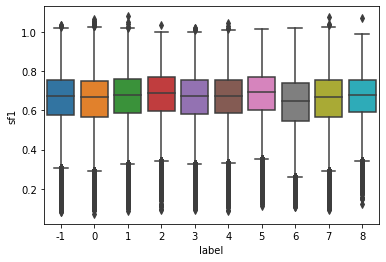

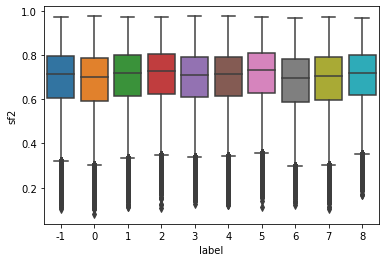

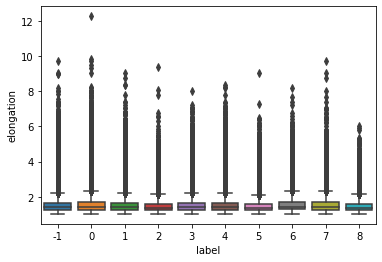

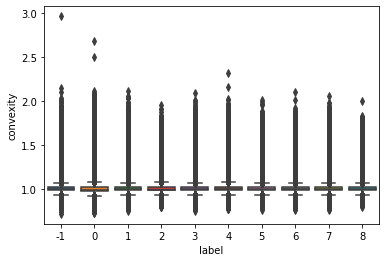

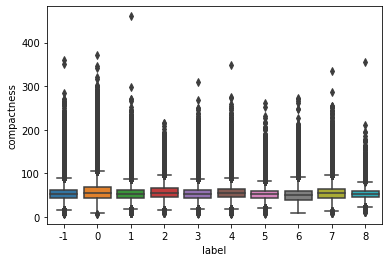

In [223]:
i = 0
for feature in FEATURES:
    fig, ax = plt.subplots()
    ax = sns.boxplot(x="label", y=feature, data=cell_shapes_all_features_df, ax=ax)
    name = f"{feature}_box_plot.png"
    output_filename = os.path.join(PATH_TO_OUTPUT_PLOTS, name)
    plt.savefig(output_filename)
    i += 1

## Load the boxplots.

In [224]:
def load_image_by_feature(feature_name):
    path_to_feature_box_plot = os.path.join(PATH_TO_OUTPUT_PLOTS, feature_name)
    return Image.open(path_to_feature_box_plot)

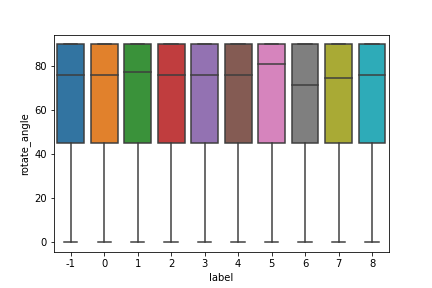

In [225]:
load_image_by_feature("rotate_angle_box_plot.png")

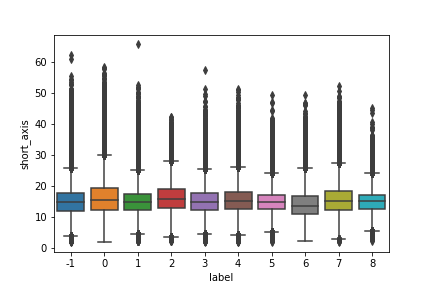

In [226]:
load_image_by_feature("short_axis_box_plot.png")

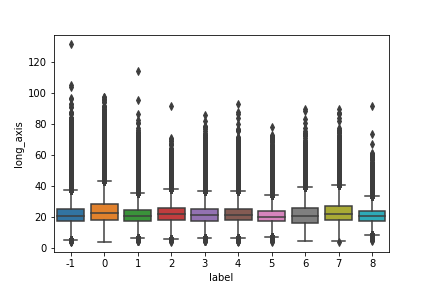

In [227]:
load_image_by_feature("long_axis_box_plot.png")

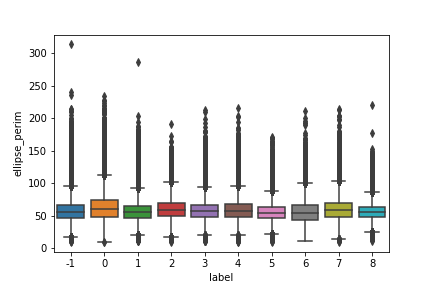

In [228]:
load_image_by_feature("ellipse_perim_box_plot.png")

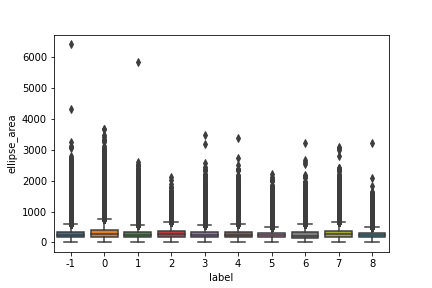

In [229]:
load_image_by_feature("ellipse_area_box_plot.png")

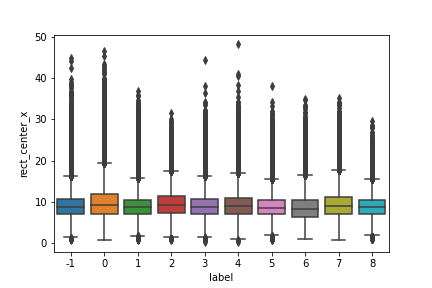

In [230]:
load_image_by_feature("rect_center_x_box_plot.png")

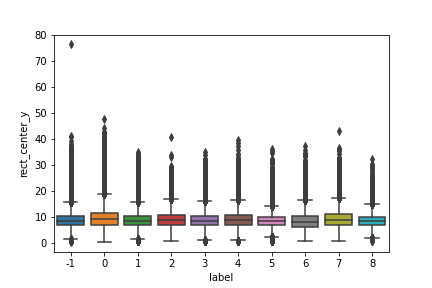

In [231]:
load_image_by_feature("rect_center_y_box_plot.png")

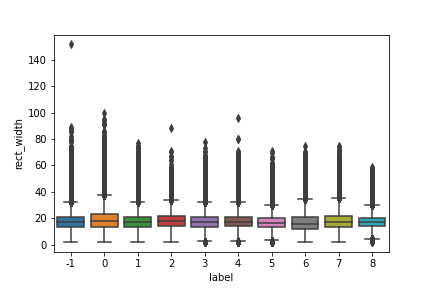

In [232]:
load_image_by_feature("rect_width_box_plot.png")

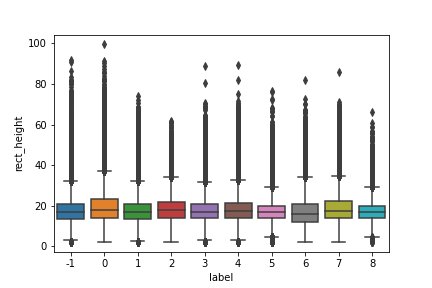

In [233]:
load_image_by_feature("rect_height_box_plot.png")

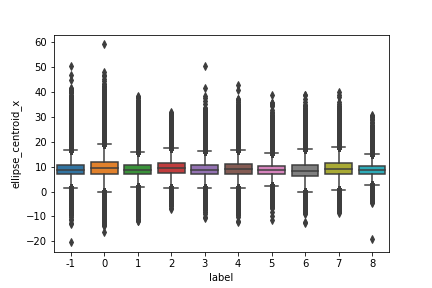

In [234]:
load_image_by_feature("ellipse_centroid_x_box_plot.png")

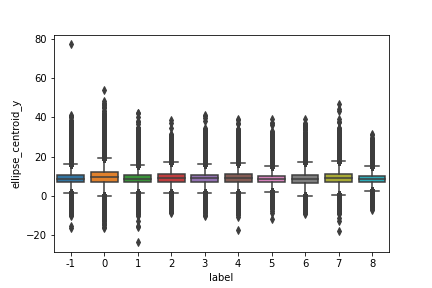

In [235]:
load_image_by_feature("ellipse_centroid_y_box_plot.png")

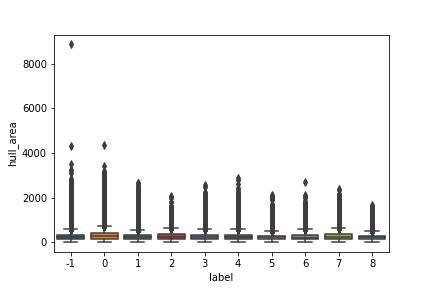

In [236]:
load_image_by_feature("hull_area_box_plot.png")

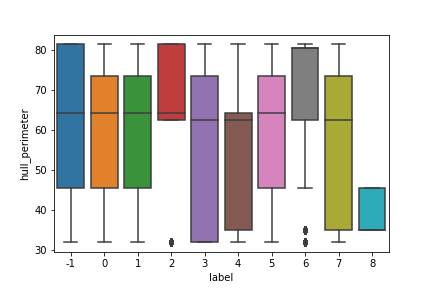

In [237]:
load_image_by_feature("hull_perimeter_box_plot.png")

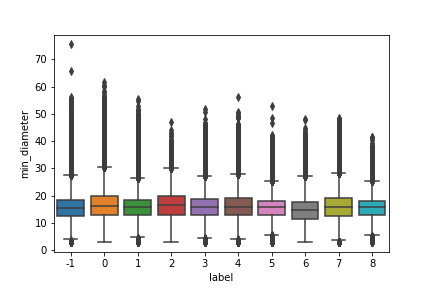

In [238]:
load_image_by_feature("min_diameter_box_plot.png")

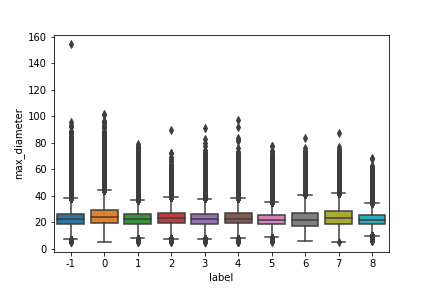

In [239]:
load_image_by_feature("max_diameter_box_plot.png")

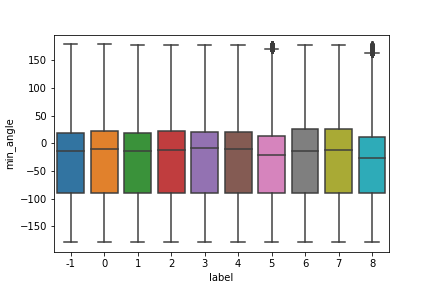

In [240]:
load_image_by_feature("min_angle_box_plot.png")

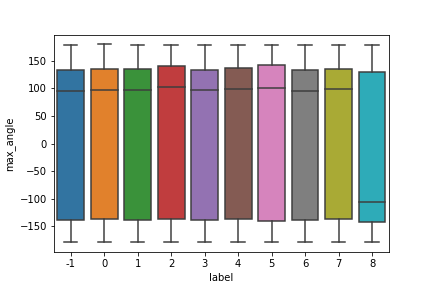

In [241]:
load_image_by_feature("max_angle_box_plot.png")

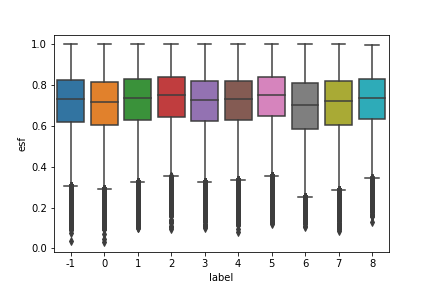

In [242]:
load_image_by_feature("esf_box_plot.png")

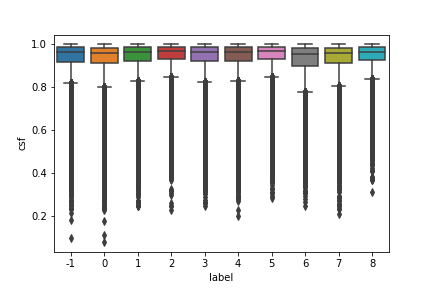

In [243]:
load_image_by_feature("csf_box_plot.png")

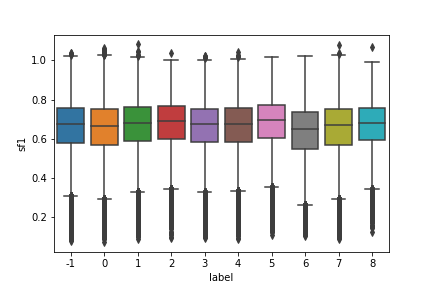

In [244]:
load_image_by_feature("sf1_box_plot.png")

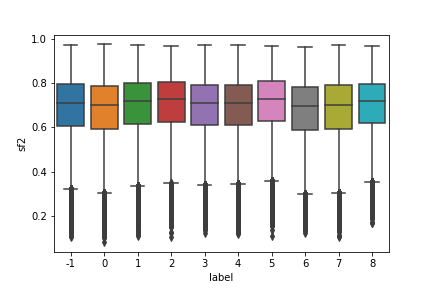

In [245]:
load_image_by_feature("sf2_box_plot.png")

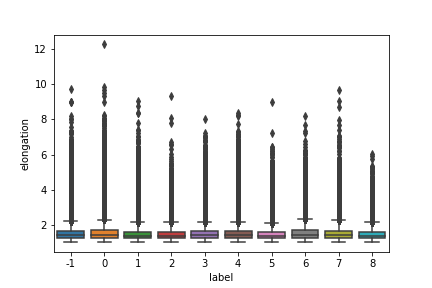

In [246]:
load_image_by_feature("elongation_box_plot.png")

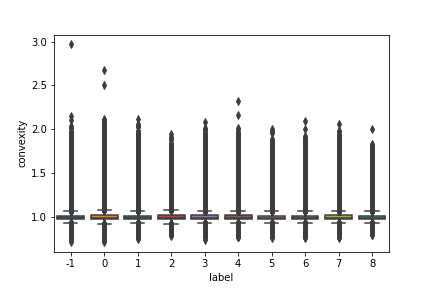

In [247]:
load_image_by_feature("convexity_box_plot.png")

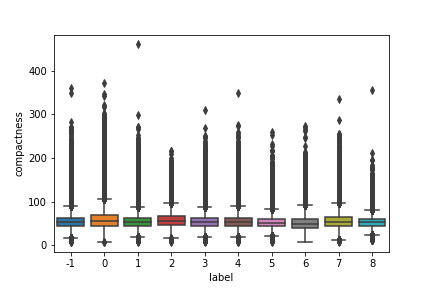

In [248]:
load_image_by_feature("compactness_box_plot.png")

In [249]:
cell_shapes_all_features_df[cell_shapes_all_features_df["long_axis"] > 1000]

,Unnamed: 0,Unnamed: 0.1,tma_id,patient_id,patch_id,cell_id,rotate_angle,short_axis,long_axis,ellipse_perim,...,max_angle,esf,csf,sf1,sf2,elongation,convexity,compactness,cell_type,label


In [250]:
path = "/deep/group/aihc-bootcamp-fall2021/lymphoma/processed/cells/tma5_cells.hdf5"

In [251]:
f = h5py.File(path, "r")
print(f.keys())

<KeysViewHDF5 ['tma5']>


In [252]:
# tma_id = 'tma5'
# patient_id = 'E0619A_v2'
# patch_id = '16'
# cell_id = '9'

tma_id = 'tma5'
patient_id = 'E0678A_v2'
patch_id = '81'
cell_id = '39'

data = f[tma_id][patient_id][patch_id][cell_id][cell_id]
cell_npy = np.zeros(data.shape)
data.read_direct(cell_npy)

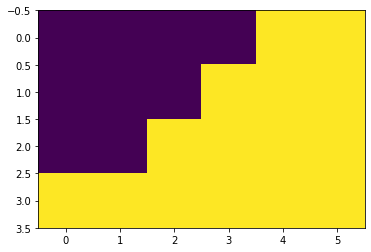

In [253]:
plt.imshow(cell_npy)

In [254]:
img = binary_fill_holes(cell_npy)
mask = img.copy()
img = img.astype(np.uint8)
img[mask] = 255

ret, thresh = cv2.threshold(img, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, 1, 2)
cnt = contours[0]

Rectangle center: (2.5, 1.5)
Rectangle width: 3.000000, height: 5.000000
Rectangle rotation angle: 90.0


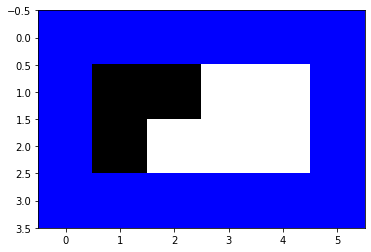

In [255]:
rect = cv2.minAreaRect(cnt)
(rectCoord1, rectCoord2, rotate_angle) = rect
box = cv2.boxPoints(rect)
box = np.int0(box)

rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb_img,[box],0,(0,0,255),1)
plt.imshow(rgb_img)

print("Rectangle center:", rect[0])
print("Rectangle width: %.6f, height: %.6f" % (rect[1][0], rect[1][1]))
print("Rectangle rotation angle:", rect[2])

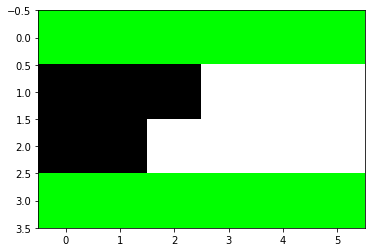

In [256]:
rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

ellipse = cv2.fitEllipseDirect(cnt)  #(x, y), (major, minor), angle                                                            
ell = cv2.ellipse(rgb_img,ellipse,(0,255,0),1)
(ellpCtr_x, ellpCtr_y), (shortAxis, longAxis), angle = ellipse
plt.imshow(rgb_img)

In [257]:
longAxis

20116.3046875

In [258]:
a = longAxis / 2
b = shortAxis / 2
e = np.sqrt(1 - b**2 / a**2)  # eccentricity                                                                                       
perimt = 4 * a * ellipe(e*e)
area = np.pi * a * b

In [259]:
print("Ellipse centroid:", (ellpCtr_x, ellpCtr_y))
print("Major axis (longAxis) length: %.6f" % longAxis)
print("Minor axis (shortAxis) length: %.6f" % shortAxis)
print("Ellipse parimeter: %.6f" % perimt)
print("Ellipse area: %.6f" % area)

Ellipse centroid: (3.5714285373687744, 1.5)
Major axis (longAxis) length: 20116.304688
Minor axis (shortAxis) length: 3.000000
Ellipse parimeter: 40232.613713
Ellipse area: 47397.926268


In [ ]:
f.close()